# Solución al "newsvendor problem" con aversión al riesgo via SDDP

## Andrés Ferragut - Unviersidad ORT Uruguay

### Semnario UTE 2020.


In [1]:
using Distributions, JuMP, GLPK, Plots, ProgressMeter

In [2]:
p = 1.0 #day ahead price
q = 2.0 #same day price

#condicion inicial de stock
X0=0.0;
L = 20; #no.de pasadas forward-backward

#parámetro de aversión al riesgo
alpha=0.5;

## Se asume demanda Uniforme[0,100] (discretizada)

In [3]:
## Defino una función que para una v.a. discreta, me calcula las probabilidades que producen el AVAR_alpha

function calculo_probs(x,p,alpha)
    #x: suporte
    #p: probabilidades
    #alpha: parametro de AVAR.
    
    orden = sortperm(x, rev=true)
    sx = x[orden]
    sp = p[orden]
    
    
    new_p = zeros(size(p))
    aux=0
    i=0
    while aux+sp[i+1]<alpha
        i=i+1
        new_p[i] = sp[i]/alpha
        aux = aux + sp[i]
    end
    
    new_p[i+1] = (alpha-aux)/alpha
    
    new_p[orden]=new_p
    return new_p
end
    
    

calculo_probs (generic function with 1 method)

In [4]:
##Pequeño test de la función anterior
soporte=[0,1,2,3]
probs=[0.4,0.3,0.2,0.1]

calculo_probs(soporte,probs,0.5)

4-element Array{Float64,1}:
 0.0
 0.3999999999999999
 0.4
 0.2

In [5]:
#array de vectores de cuts. Arranca en la lower bound del costo
cuts = [[0.0;0.0]];
explored_states=[100.0];
costos_forward=Float64[];

@showprogress for i=1:L
    
    
    #### PROBLEMA FORWARD

    model = JuMP.Model(GLPK.Optimizer)
    set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_OFF) ##apago los logs
    
    @variable(model,u0>=0);
    @variable(model,x0>=0);
    @variable(model,z);

    ## agrego los cortes como constraints
    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2]*(x0+u0));
    end

    #Fijo el stock imicial
    fix_x = @constraint(model,x0==X0);

    @objective(model,Min,p*u0+z);

    optimize!(model)

    ##Valor de stock luego de la primera compra (pasada forward)
    X1=value(x0)+value(u0);
    
    #Guardo el costo obtenido
    push!(costos_forward,objective_value(model))
    
    #### PROBLEMA BACKWARD

    #resuelvo para todos los ruidos el segundo paso y agrego un corte para cada uno.
    local_betas = Float64[];
    local_lambdas = Float64[];
    
    for demand=(0:100)        

        model = JuMP.Model(GLPK.Optimizer)
        set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_OFF) ##apago los logs
        
        @variable(model,u1>=0);
        @variable(model,x1>=0);

        #stock al final positivo
        @constraint(model,x1+u1-demand>=0);

        #Fijo el stock a la entrada al valor de la pasada forward
        #El dual de esta restricción es la pendiente del corte.
        fix_x = @constraint(model,x1==X1);

        @objective(model,Min,q*u1);

        optimize!(model)

        beta = objective_value(model);
        lambda = dual(fix_x)

        push!(local_lambdas,lambda)
        push!(local_betas,beta)

    end

    #En el vector local_betas, quedan las realizaciones del costo. Calculo las probs para AVAR.
    pesos = calculo_probs(local_betas,ones(size(local_betas))/length(local_betas),alpha)
    ##Promedio los cortes locales con los pesos obtenidos, agrego uno nuevo, y vuelvo a la pasada forward
    avg_beta = sum(pesos.*local_betas)
    avg_lambda = sum(pesos.*local_lambdas)
    
    new_cut = [avg_beta-avg_lambda*X1;avg_lambda]
    push!(cuts,new_cut);
    push!(explored_states,X1)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


### Animación de los cortes

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/risk_averse_sddp/tmp.gif
└ @ Plots /home/andres/.julia/packages/Plots/4EfKl/src/animation.jl:104


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/risk_averse_sddp/tmp.gif")
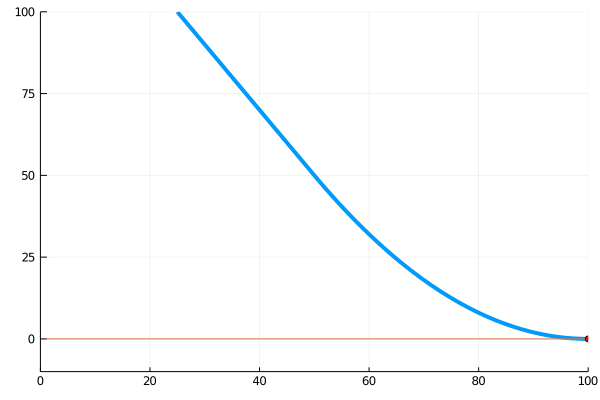

In [6]:
##Función de costo futuro (ver slides)
V(x,alpha) = q*((100*(1-alpha/2)-x)*(x<100*(1-alpha))  + (100-x)^2/(2*100*alpha)*(x>=100*(1-alpha)) ) 

#Ploteo los cuts obtenidos
x=(0:100)
pl=plot(;legend=:none,xlim=(0,100),ylim=(-10,100))

#Ploteo la función de costo futuro calculada teorica
plot!(pl,x,V.(x,alpha),lw=4)

anim=nothing
anim = @animate for i=1:length(cuts)
    cut=cuts[i]
    plot!(pl,cut[1].+cut[2]*x);
    scatter!(pl,[explored_states[i]],[V(explored_states[i],alpha)], markersize=4, markercolor=:red)
end

gif(anim,"tmp.gif",fps=1)

### Evolución del costo forward.

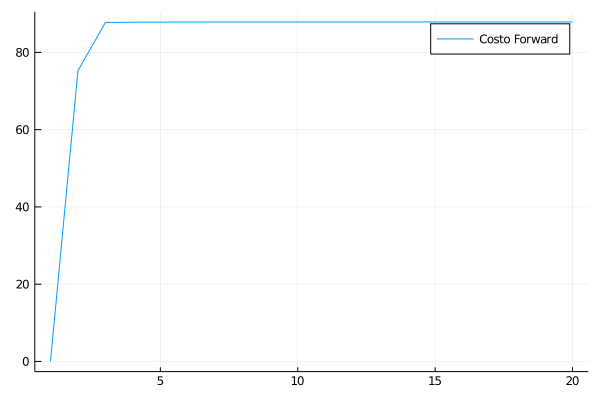

In [7]:
plot((1:L),costos_forward, label="Costo Forward")

### Resuelvo el problema de stock

In [8]:
#resuelvo una vez mas para hallar el costo calculado
model = JuMP.Model(GLPK.Optimizer)
set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_OFF) ##apago los logs
    
@variable(model,u0>=0);
@variable(model,x0>=0);
@variable(model,z);

## agrego los cortes como constraints
for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(x0+u0));
end

#Fijo el stock imicial
fix_x = @constraint(model,x0==X0);

@objective(model,Min,p*u0+z);

optimize!(model)

In [9]:
X1=value(x0)+value(u0);
costo = objective_value(model);

println("Costo calculado: $costo")
println("Control calculado: $X1")


Costo calculado: 87.87128712871286
Control calculado: 74.99999999999999
